In [17]:
import numpy as np
import matplotlib.pyplot as plt

from abtem.ionization import SubshellTransitions, TransitionPotential, EELSDetector
from abtem import SMatrix, Potential, GridScan

from ase import units
from ase.io import read

# Core loss EELS with SrTiO3 (early experimental version)

We calculate the energy filtered STEM image of SrTiO3 targeting Oxygen, specifically we target the K-edge (or the 1s subshell (or the quantum numbers $(n, \ell) = (1, 0)$)). In an experiment this is  equivalent to setting your energy filter to 456 eV.

The following code calculates projected overlap integrals following to Dwyer *et al.* (see https://doi.org/10.1016/j.ultramic.2005.03.005 or https://doi.org/10.1103/PhysRevB.57.3273), dynamical scattering following [Brown *et al.*](https://doi.org/10.1103/PhysRevResearch.1.033186) and uses the density functional theory code [GPAW](https://wiki.fysik.dtu.dk/gpaw/index.html) for calculating wave functions. Please see our citation guide if you use this code in a publication.

In [2]:
Z = 8 # atomic number
n = 1 # principal quantum number
l = 0 # azimuthal quantum number
xc = 'PBE' # exchange correltation functional

O_transitions = SubshellTransitions(Z = Z, n = n, l=l, xc='PBE')

print('bound electron configuration:', O_transitions.bound_configuration)
print('ionic electron configuration:', O_transitions.excited_configuration)

bound electron configuration: 1s2 2s2 2p4
ionic electron configuration: 1s1 2s2 2p4


Applying the selection rules

$$
 \Delta \ell = \pm 1 \quad\mathrm{and}\quad \Delta m = 0, \pm 1
$$

we obtain the following dipole transitions.

In [3]:
for bound_state, continuum_state in O_transitions.get_transition_quantum_numbers():
    print(f'(ell, ml) = {bound_state} -> {continuum_state}')

(ell, ml) = (0, 0) -> (1, -1)
(ell, ml) = (0, 0) -> (1, 0)
(ell, ml) = (0, 0) -> (1, 1)


For a fast electron at 100 keV and a specified grid, we obtain the following transition potentials. The code will run an all-electron density function theory calculation using GPAW.

In [4]:
atomic_transition_potentials = O_transitions.get_transition_potentials(extent=5, gpts=256, energy=100e3)

Transitions:   0%|          | 0/3 [00:00<?, ?it/s]

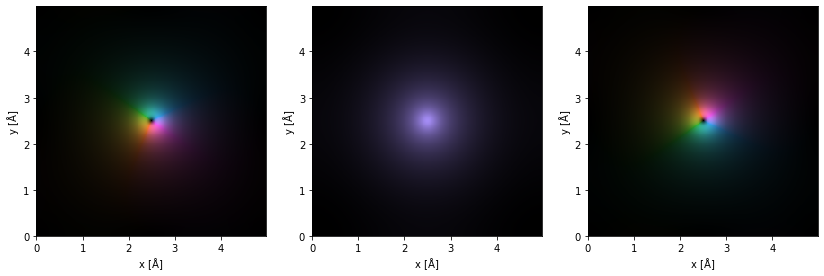

In [5]:
fig, axes= plt.subplots(1,3, figsize=(14,6))

for ax, atomic_transition_potential in zip(axes, atomic_transition_potentials):    
    atomic_transition_potential.show(ax=ax, title=str(atomic_transition_potential))

We have created transition potentials for single atoms, now we need to put them together in a multislice simulation.

We import our `Atoms` as usual.

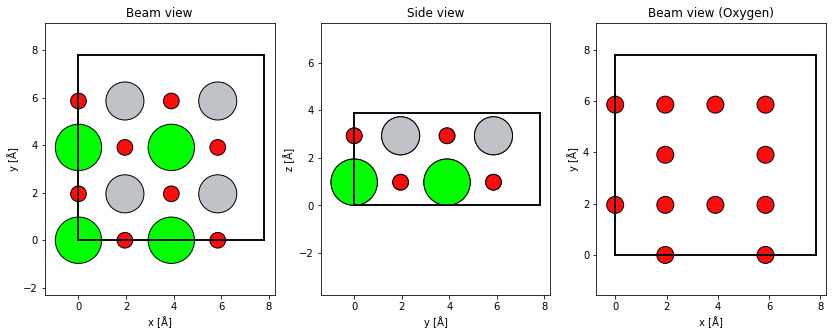

In [6]:
atoms = read('srtio3_100.cif') * (2,2,1)
atoms.center(axis=2)

from abtem import show_atoms
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(14,5))

show_atoms(atoms, ax=ax1, title='Beam view')
show_atoms(atoms, ax=ax2, plane='yz', title='Side view')
show_atoms(atoms[atoms.numbers == 8], ax=ax3, plane='xy', title='Beam view (Oxygen)');

Next, we create a `TransitionPotential`. The overlap integrals depent on the incoming energy, hence we have to provide the acceleration voltage. We also provide a sampling in order to show the potential below.

In [7]:
transition_potential = TransitionPotential(O_transitions, atoms=atoms, sampling=.05, energy=100e3, slice_thickness=2)

We can show the projected intensity of the potential.

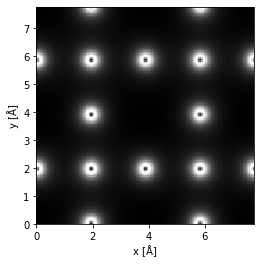

In [8]:
transition_potential.show()

Finally, we can do a full energy filtered STEM simulation targeting the Oxygen K edge.

We create a scattering matrix as usual (interpolation is not yet implemented), and an `EELSDetector` (interpolation is implemented). We create a standard electrotrostatic potential as well. 

NOTE: Interpolation is not currently implemented for the `SMatrix`, it *is* implemented for the `EELSDetector`.

We also create a new `TransitionPotential`, the new potential will automatically adopt the appropritate atoms and energy from the other simulation objects.

In [9]:
S = SMatrix(energy=100e3, semiangle_cutoff=25) # interpolation not implemented


detector = EELSDetector(collection_angle=100, interpolation=4)


potential = Potential(atoms, sampling=.05, slice_thickness=.5, projection='infinite', parametrization='kirkland')


transition_potential = TransitionPotential(O_transitions)


scan = GridScan((0,0), potential.extent, sampling=.9*S.ctf.nyquist_sampling)


measurement = S.coreloss_scan(scan, detector, potential, transition_potential)

Potential:   0%|          | 0/8 [00:00<?, ?it/s]

Backward multislice:   0%|          | 0/89 [00:00<?, ?it/s]

Forward multislice:   0%|          | 0/8 [00:00<?, ?it/s]

We show the final energy filtered image below.

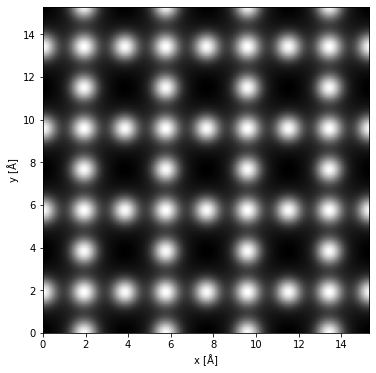

In [10]:
measurement.tile((2,2)).interpolate(.02).show(figsize=(6,6));

We target the $K$-edge of oxygen as above and the $L_{23}$-edge of titanium and strontium.

In [11]:
O_transitions = SubshellTransitions(Z = 8, n = 1, l=0, xc='PBE')
Ti_transitions = SubshellTransitions(Z = 22, n = 2, l=1, xc='PBE')
Sr_transitions = SubshellTransitions(Z = 38, n = 2, l=1, xc='PBE')

transitions = [O_transitions, Ti_transitions, Sr_transitions]

transition_potential = TransitionPotential(transitions)

In [12]:
print('Oxygen:')
for bound_state, continuum_state in O_transitions.get_transition_quantum_numbers():
    print(f'(ell, ml) = {bound_state} -> {continuum_state}')
print('Titanium:')
for bound_state, continuum_state in Ti_transitions.get_transition_quantum_numbers():
    print(f'(ell, ml) = {bound_state} -> {continuum_state}')
print('Strontium:')
for bound_state, continuum_state in Sr_transitions.get_transition_quantum_numbers():
    print(f'(ell, ml) = {bound_state} -> {continuum_state}')

Oxygen:
(ell, ml) = (0, 0) -> (1, -1)
(ell, ml) = (0, 0) -> (1, 0)
(ell, ml) = (0, 0) -> (1, 1)
Titanium:
(ell, ml) = (1, -1) -> (0, 0)
(ell, ml) = (1, -1) -> (2, -2)
(ell, ml) = (1, -1) -> (2, -1)
(ell, ml) = (1, -1) -> (2, 0)
(ell, ml) = (1, 0) -> (0, 0)
(ell, ml) = (1, 0) -> (2, -1)
(ell, ml) = (1, 0) -> (2, 0)
(ell, ml) = (1, 0) -> (2, 1)
(ell, ml) = (1, 1) -> (0, 0)
(ell, ml) = (1, 1) -> (2, 0)
(ell, ml) = (1, 1) -> (2, 1)
(ell, ml) = (1, 1) -> (2, 2)
Strontium:
(ell, ml) = (1, -1) -> (0, 0)
(ell, ml) = (1, -1) -> (2, -2)
(ell, ml) = (1, -1) -> (2, -1)
(ell, ml) = (1, -1) -> (2, 0)
(ell, ml) = (1, 0) -> (0, 0)
(ell, ml) = (1, 0) -> (2, -1)
(ell, ml) = (1, 0) -> (2, 0)
(ell, ml) = (1, 0) -> (2, 1)
(ell, ml) = (1, 1) -> (0, 0)
(ell, ml) = (1, 1) -> (2, 0)
(ell, ml) = (1, 1) -> (2, 1)
(ell, ml) = (1, 1) -> (2, 2)


In [13]:
measurements = S.coreloss_scan(scan, detector, potential, transition_potential)

Potential:   0%|          | 0/8 [00:00<?, ?it/s]

Backward multislice:   0%|          | 0/89 [00:00<?, ?it/s]

Forward multislice:   0%|          | 0/8 [00:00<?, ?it/s]

By abTEM convention the first dimensions always represent the scan or navigation dimensions. Hence, inour case the third dimension represents the subshell of an electron (or experimentally a specific energy loss).

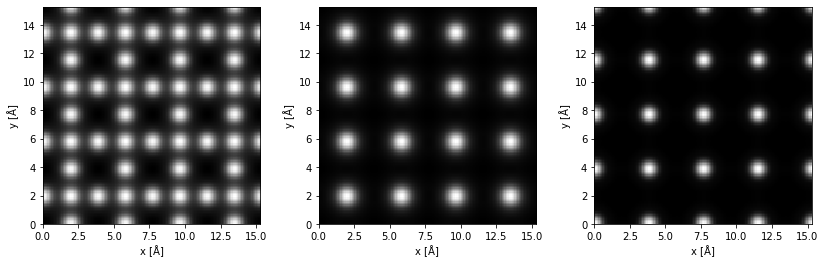

In [14]:
fig,(ax1,ax2,ax3)= plt.subplots(1,3, figsize=(14,4))

measurements[0].tile((2, 2)).interpolate(.1).show(ax=ax1)
measurements[1].tile((2, 2)).interpolate(.1).show(ax=ax2)
measurements[2].tile((2, 2)).interpolate(.1).show(ax=ax3);

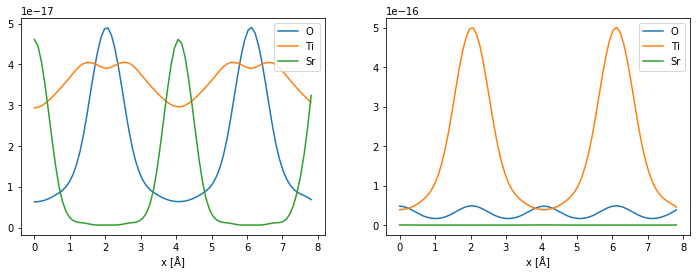

In [15]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
measurements[0].interpolate_line((0,0),(0,potential.extent[1]), sampling=.1).show(ax=ax1, label='O')
measurements[1].interpolate_line((0,0),(0,potential.extent[1]), sampling=.1).show(ax=ax1, label='Ti')
measurements[2].interpolate_line((0,0),(0,potential.extent[1]), sampling=.1).show(ax=ax1, label='Sr')
ax1.legend()

measurements[0].interpolate_line((atoms[3].x,0),(atoms[3].x,potential.extent[1]), sampling=.1).show(ax=ax2, label='O')
measurements[1].interpolate_line((atoms[3].x,0),(atoms[3].x,potential.extent[1]), sampling=.1).show(ax=ax2, label='Ti')
measurements[2].interpolate_line((atoms[3].x,0),(atoms[3].x,potential.extent[1]), sampling=.1).show(ax=ax2, label='Sr')
ax2.legend()